In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import pickle
from pprint import pprint
from collections import Counter
from transformers import AutoTokenizer

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(
    'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    model_max_length=512,
    padding_side='left',
    trust_remote_code=True,
    use_fast=False,
)

/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
def get_name(node):
    name = '<s>' if not node.depth else tokenizer.decode(node.action)
    name = name.replace('\\', '/')
    text = '[{}] {}'.format(node.N, name)
    tokens = text.split()
    num_per_line = (int(len(tokens) ** .5) + 1)# * 2
    line_cnt = (len(tokens) + num_per_line - 1) // num_per_line
    name = '\n'.join(' '.join(tokens[i*num_per_line: (i+1)*num_per_line]) for i in range(line_cnt))
    try:
        p = node.p
    except:
        p = 1
    # return name + '\n(Q: {:.5f}) (P: {:.5f}) (R: {:.5f})'.format(node.Q, p, np.exp(node.reward))
    return name + '\n(Q: {:.5f}) (P: {:.5f}) \n (V: {:.5f}) \n terminal:{}'.format(node.Q if node.Q is not None else -1, p, node.V, node.is_terminal)

def add_edges_with_path(graph, node, parent_name, path, cur_node):
    child_name = get_name(node)
    if node in path:
        graph.add_edge(parent_name, child_name, color = "red")
        if node == cur_node:
            graph.nodes[child_name]['color'] = 'green'
        else:
            graph.nodes[child_name]['color'] = 'red'
    else:
        graph.add_edge(parent_name, child_name, color = "blue")
    v = node.children
    if v is not None:
        for vv in v:
            add_edges_with_path(graph, vv, child_name, path, cur_node)

def draw_tree_with_path(tree, cur_node, path, fig=None, ax=None):
    graph = nx.DiGraph()
    k = get_name(tree)
    if tree in path:
        if tree == cur_node:
            graph.add_node(k, color = "green")
        else:
            graph.add_node(k, color = "red")
    else:
        graph.add_node(k, color = "blue")
    v = tree.children
    if v is not None:
        for vv in v:
            add_edges_with_path(graph, vv, k, path, cur_node)    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use the pygraphviz layout for horizontal tree structure
    pos = nx.nx_agraph.graphviz_layout(graph, prog='dot', args='-Grankdir=LR')

    node_colors = [graph.nodes[n].get('color', 'blue') for n in graph.nodes]
    edge_colors = [graph[u][v].get('color', 'blue') for u, v in graph.edges]
    nx.draw(graph, pos, with_labels=True, arrows=False, ax=ax, font_size=16, node_color=node_colors, edge_color=edge_colors)
    ax.set_title("Tree Visualization")
    fig.set_facecolor("w")
    fig.subplots_adjust(left=0.05, right=1.00, top=1.01, bottom=.01)
    # fig.savefig(save_pth, format='pdf')
    plt.show()

In [3]:
def print_prompt_and_answer(output_path, file_name='mcts_rst_prompt_answer.pkl'):
    with open(f'{output_path}/{file_name}', 'rb') as f:
        dump_data = pickle.load(f)

    prompt = tokenizer.decode(dump_data['input_ids'])
    answer = dump_data['answer']
    reasoning = dump_data['reasoning']

    print(f"\nPrompt: {prompt}")
    print(f"\nAnswer: {answer}")
    print(f"\nReasoning: {reasoning}")

In [5]:
output_dir = '/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs'
epoch = 0
batch_cnt = 0
output_dir = f'{output_dir}/epoch_{epoch}/batch_cnt_{batch_cnt}'
print_prompt_and_answer(output_dir)


Prompt: <s> <|start_header_id|>user<|end_header_id|>

Gerald wants to buy a meat pie that costs 2 pfennigs. Gerald has 54 farthings, and there are 6 farthings to a pfennig. How many pfennigs will Gerald have left after buying the pie?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



Answer: 7

Reasoning: First convert the number of farthings Gerald has to pfennigs by dividing by the exchange rate: 54 farthings / 6 farthings/pfennig = <<54/6=9>>9 pfennigs
Then subtract the cost of the meat pie to find how many pfennigs Gerald has left: 9 pfennigs - 2 pfennigs = <<9-2=7>>7 pfennigs
#### 7
The answer is 7


In [14]:
def visualize_iteration_trees(output_dir, node_cnt, iteration):
    output_dir = f'{output_dir}/node_{node_cnt}/{iteration}'
    for file in sorted(os.listdir(output_dir)):
        visualize_iteration_tree(output_dir, file)

def visualize_iteration_tree(output_dir, file):
        with open(f'{output_dir}/{file}', 'rb') as f:
            dump_data = pickle.load(f)
            print(f'{output_dir}/{file}')
        cur_node = dump_data['cur_node']
        path = dump_data['path']
        node = cur_node
        while node.depth:
            node = node.parent
        root = node
        fig, ax = plt.subplots(figsize=(30, 20))
        draw_tree_with_path(root, cur_node, path, fig, ax)

# Step 0

## Iteration 0

One Iteration of select, evaluate and expand. The first call to the mcts search algorithm calls the search() function which further invokes iterate() for n_iter amount of times. The function iterate() expands the leaf nodes starting from the current root (shown in green) and selects the path through the tree using the PUCT value. During iteration 0, the root node is expaned and 3 children are added. The best child is then further expanded until a terminal node is reached. The last image shows the resulting reward from the backpropagation process. 

[2025-06-27 18:08:39,442] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/chalbeise/miniconda3/envs/mcts-dpo/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


[2025-06-27 18:08:40,990] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


/home/chalbeise/miniconda3/envs/mcts-dpo/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/0/mcts_rst_0.pkl


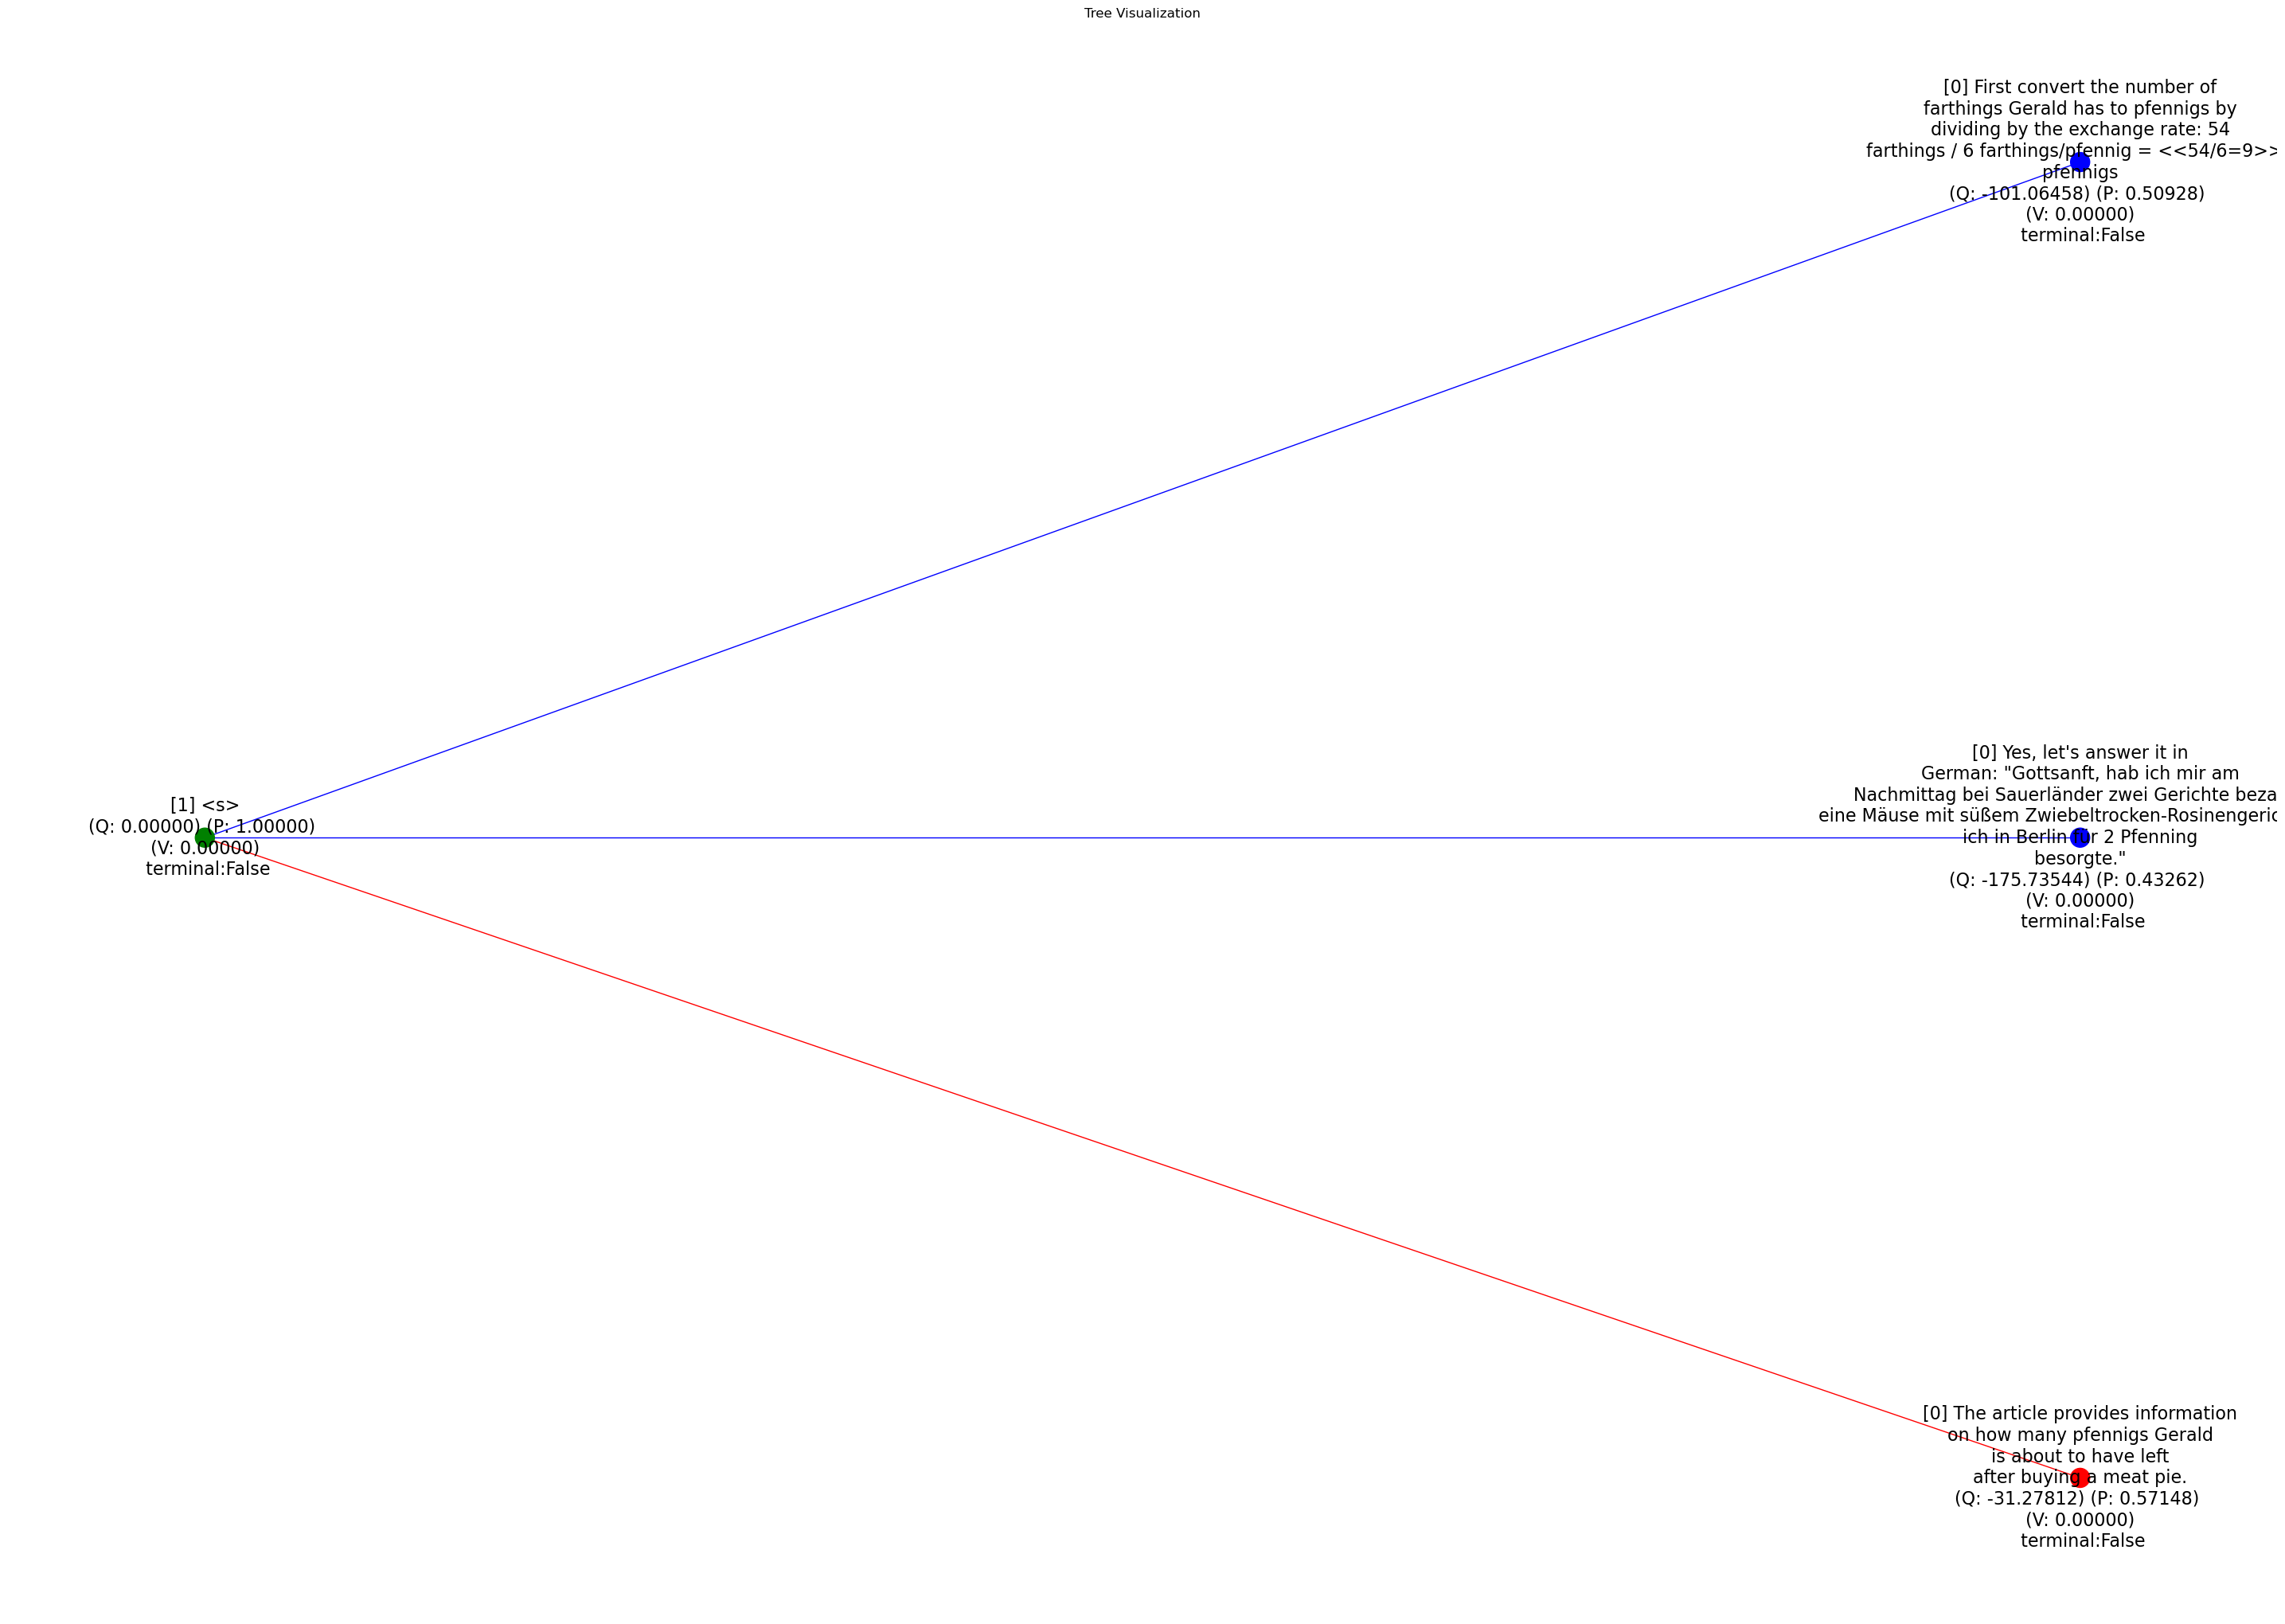

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/0/mcts_rst_1.pkl


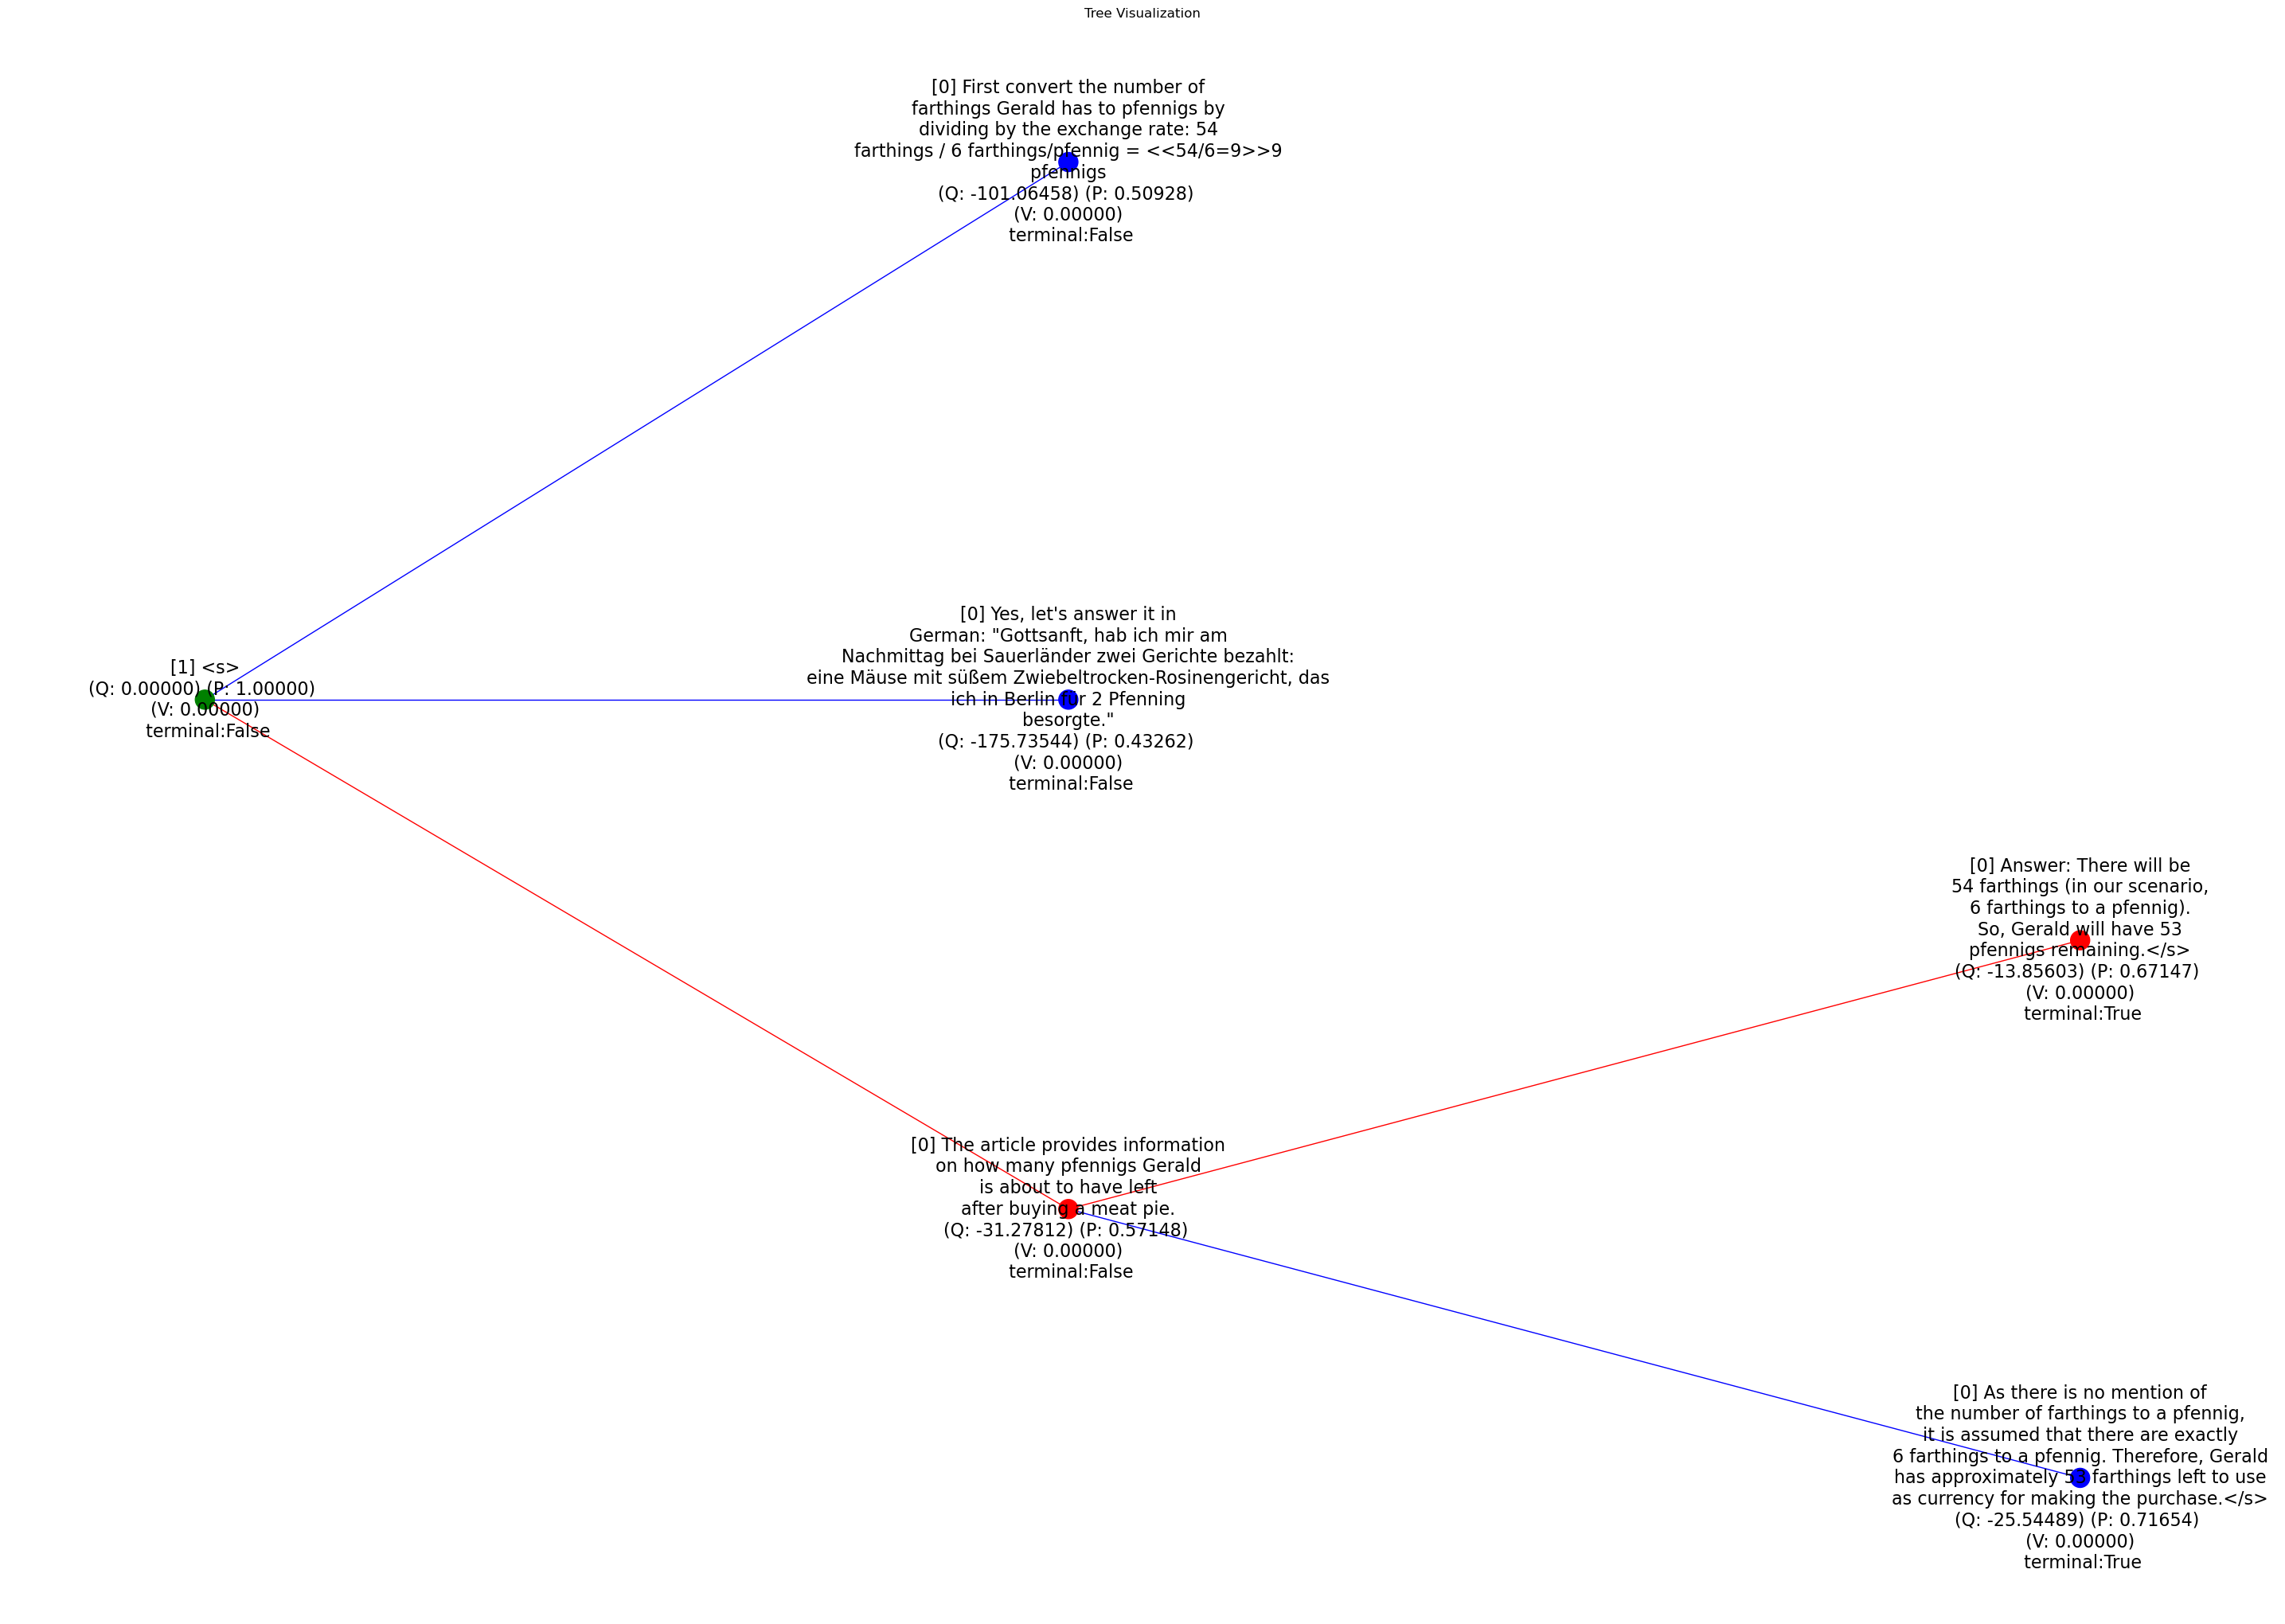

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/0/mcts_rst_2_bckp.pkl


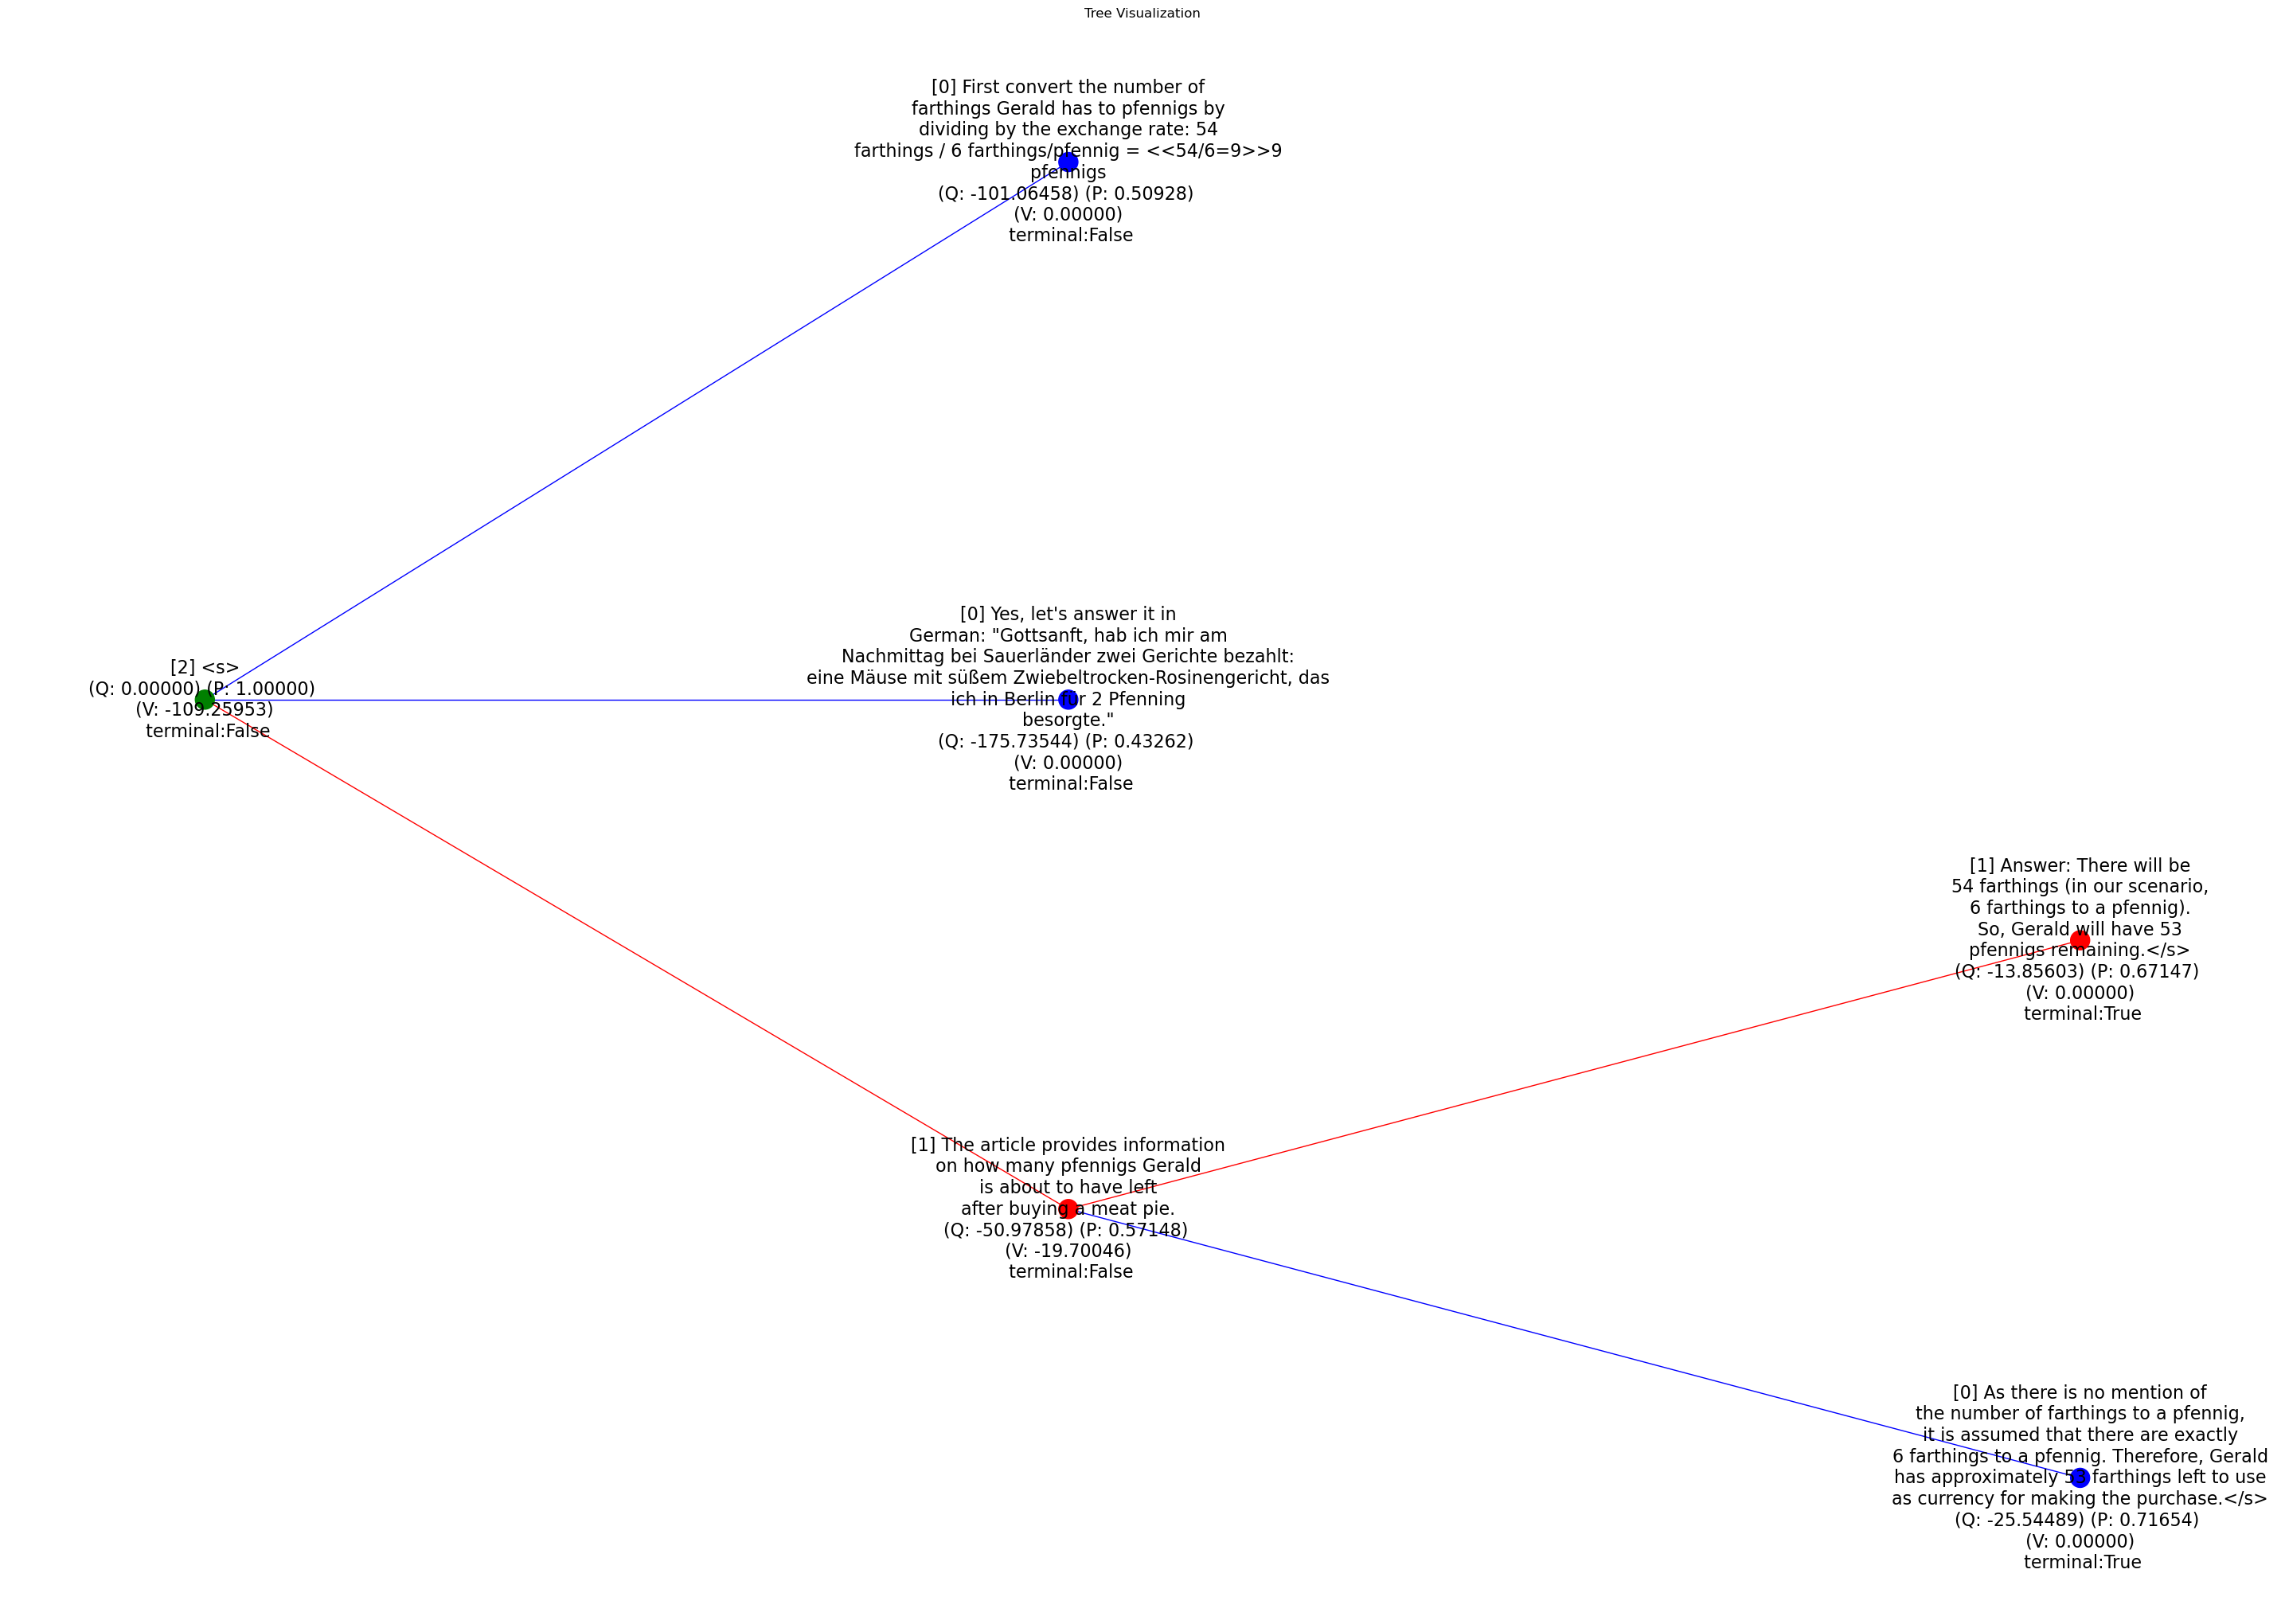

In [ ]:
node_cnt = 0
iteration = 0
visualize_iteration_trees(output_dir, node_cnt, iteration)

## Iteration 1

After the first iteration the reward from the first chosen path is backpropagated and a new path is built from the root, selecting again the child nodes with the best PUCT values.

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/1/mcts_rst_0_bckp.pkl


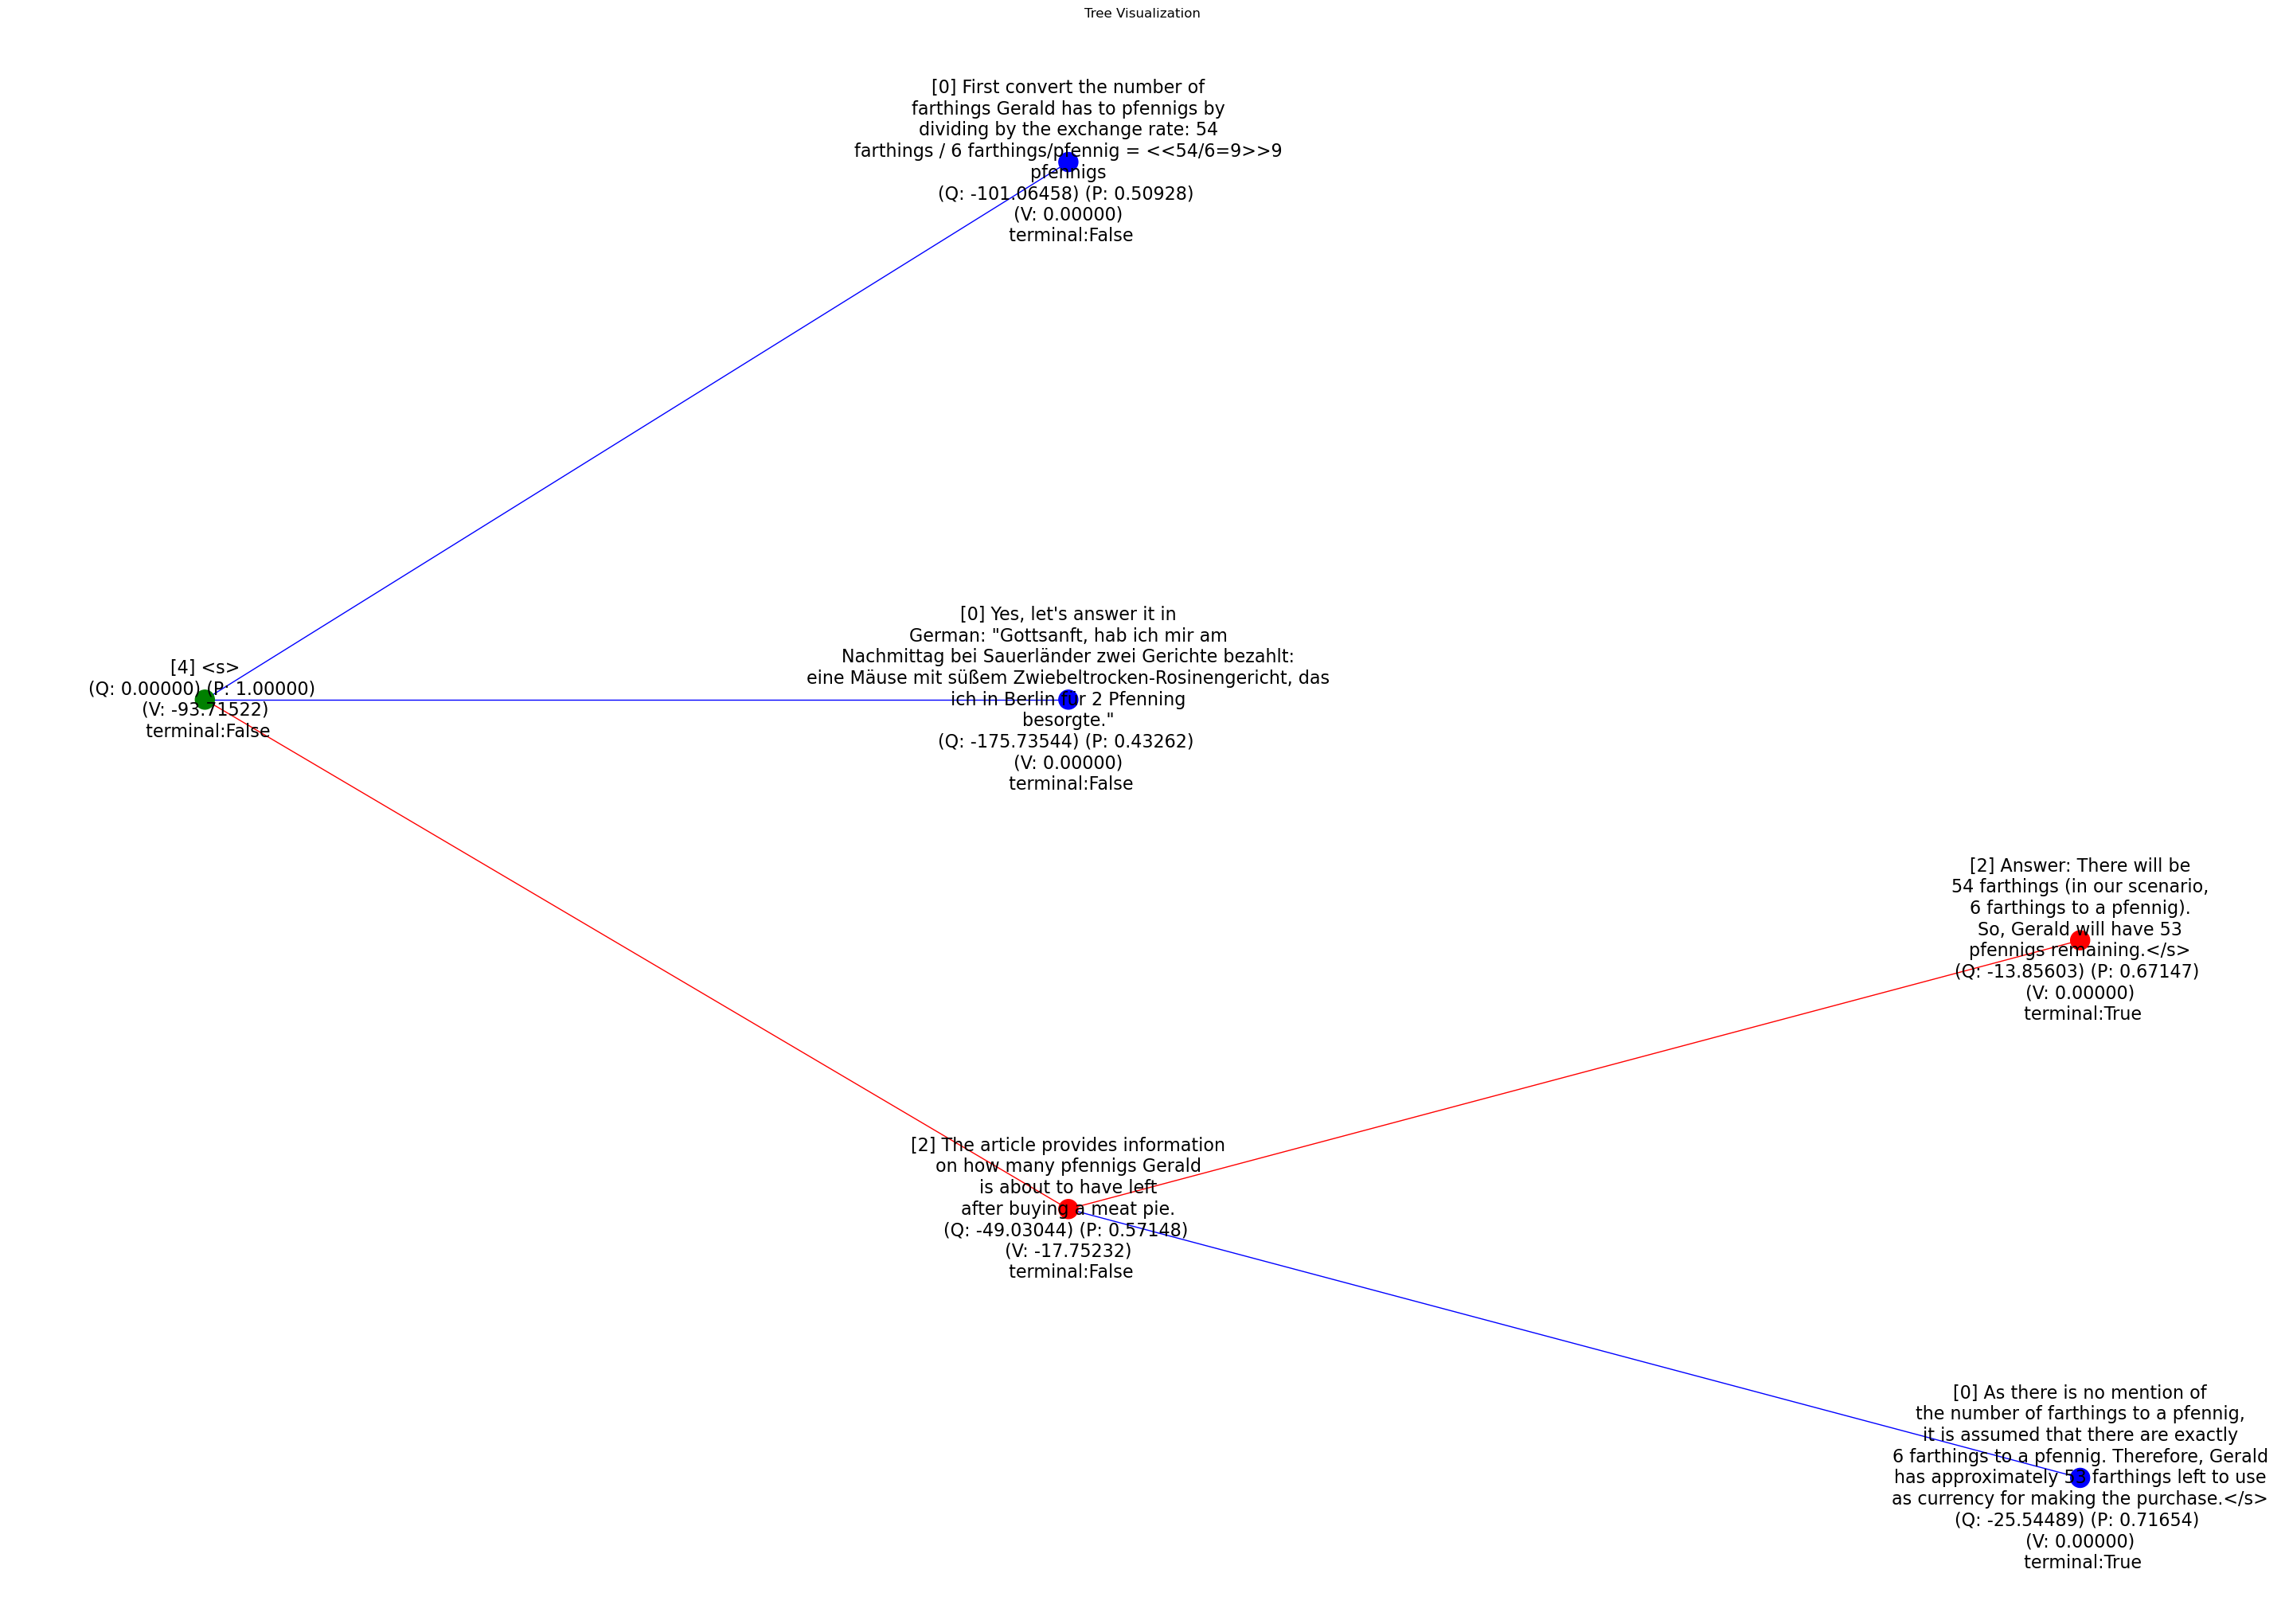

In [ ]:
iteration = 1
visualize_iteration_trees(output_dir, node_cnt, iteration)

## Iteration 2

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/2/mcts_rst_0_bckp.pkl


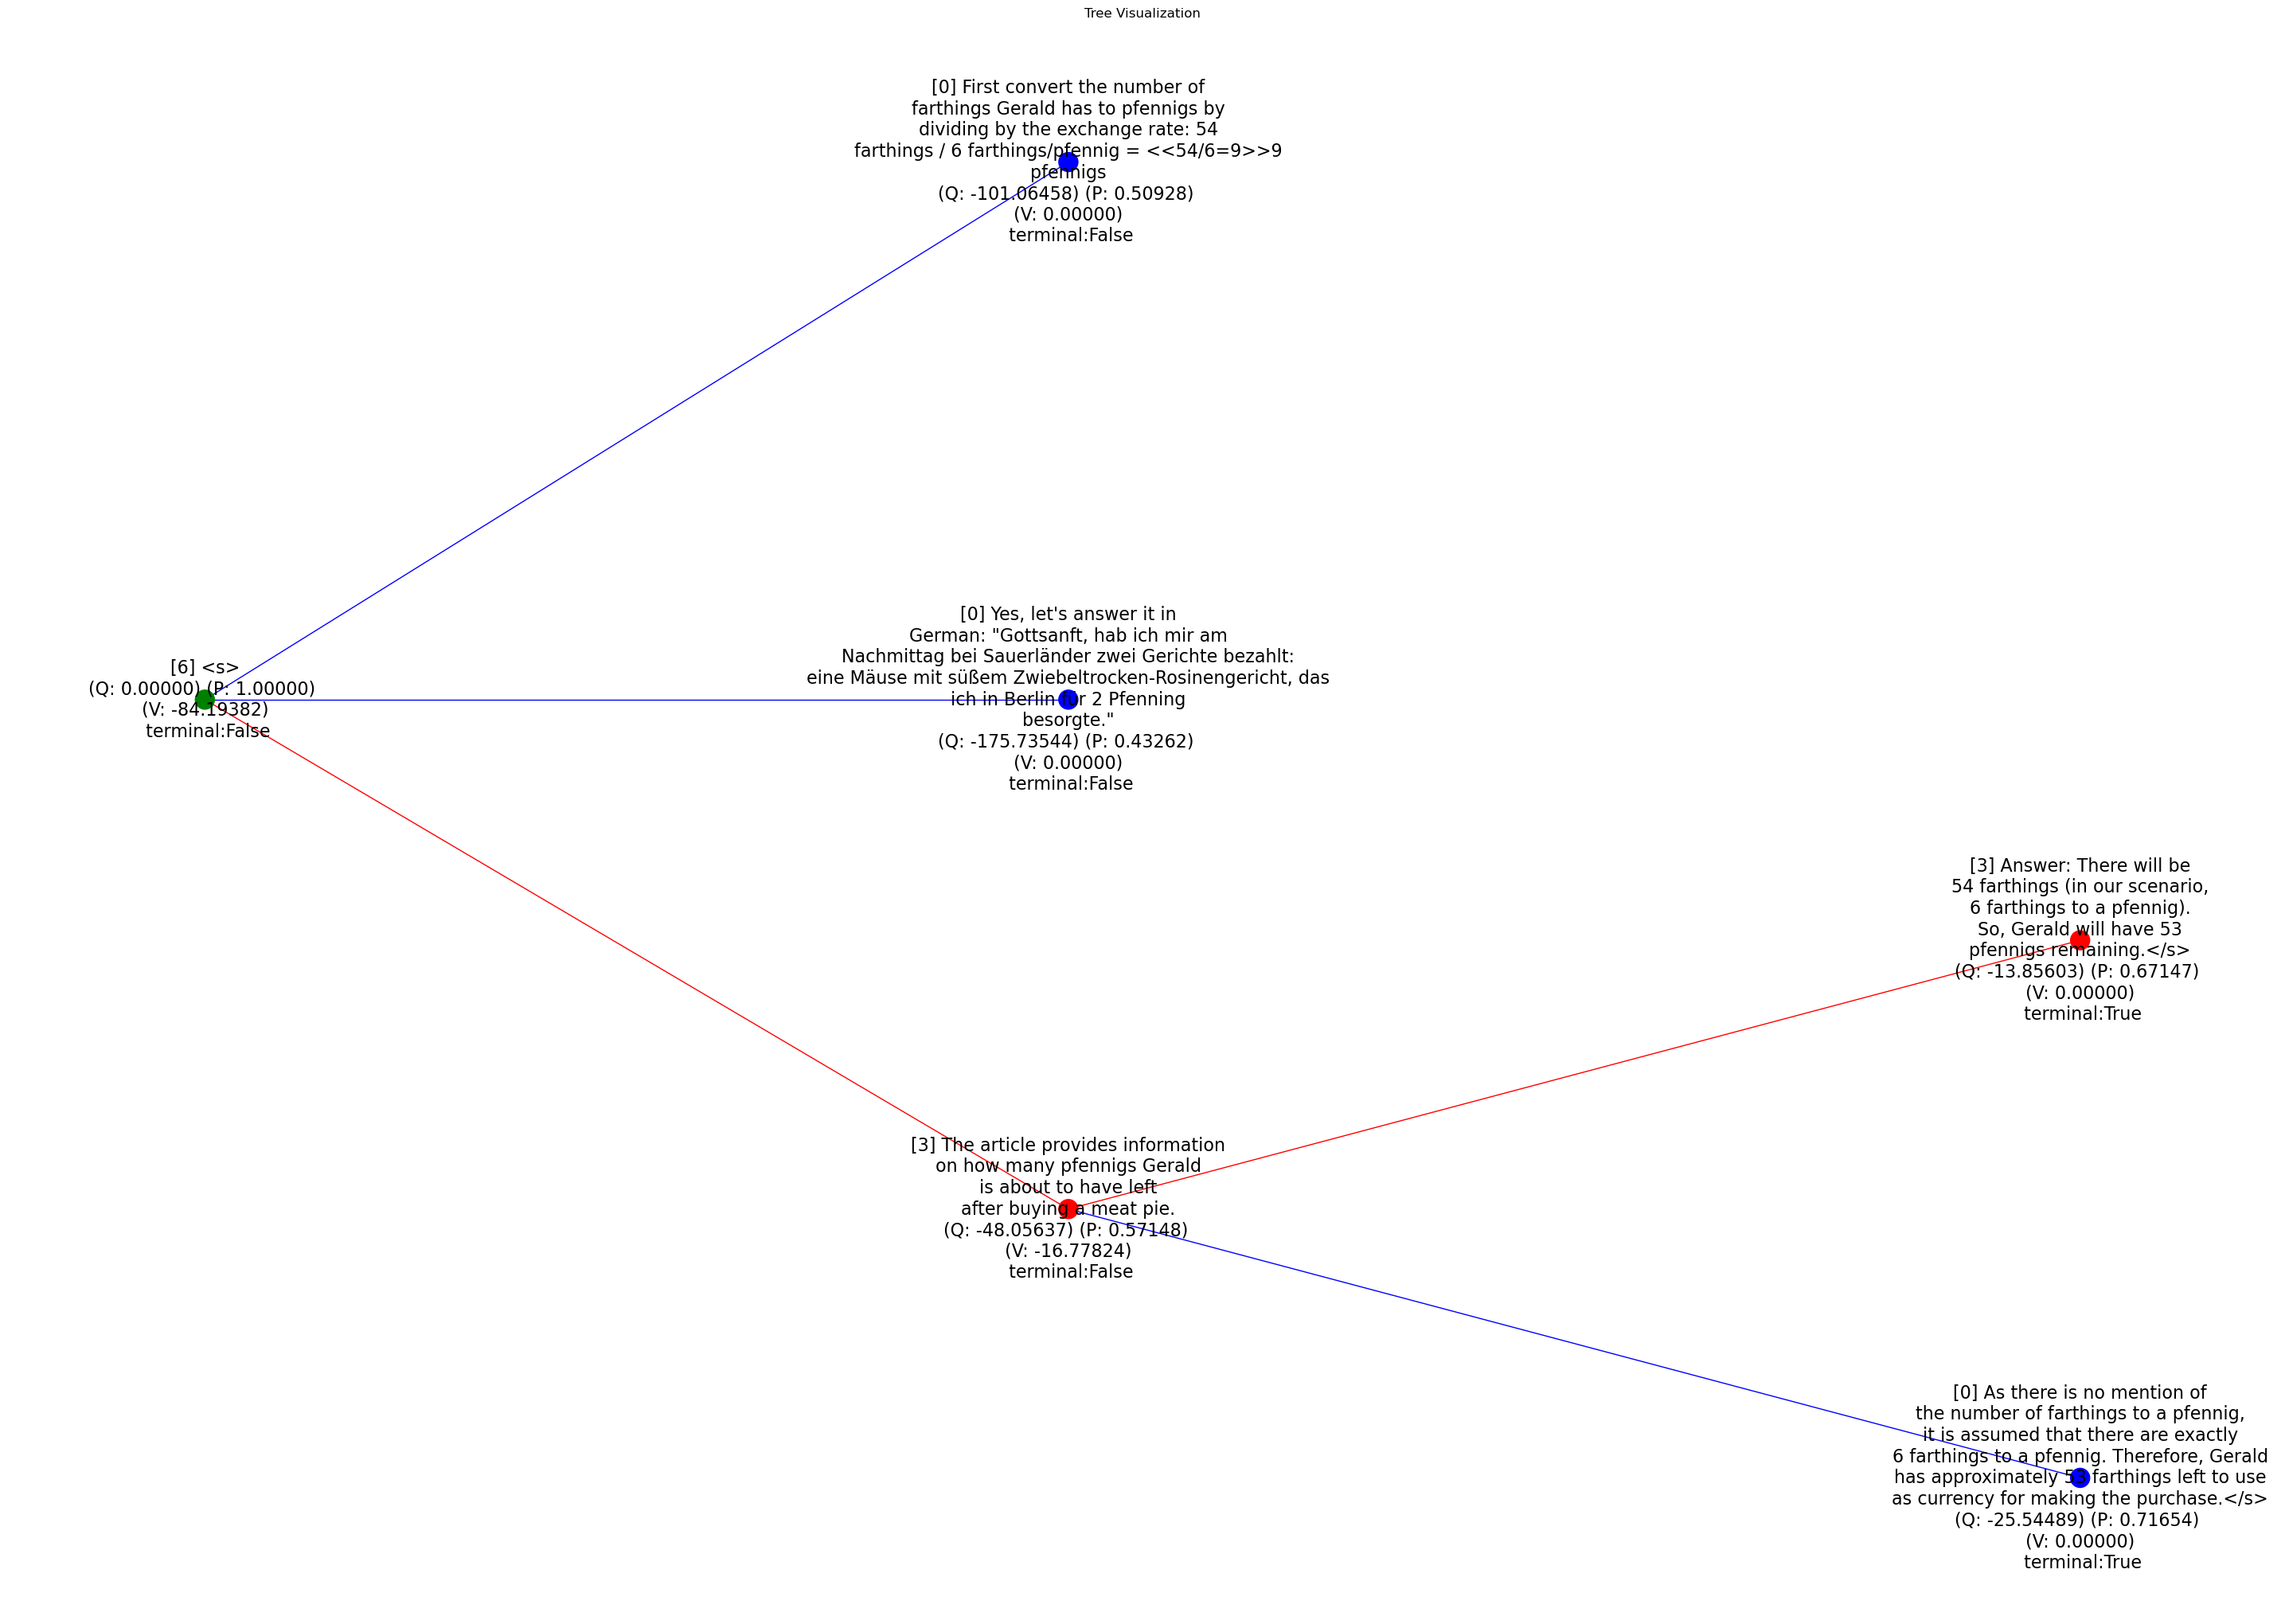

In [ ]:
iteration = 2
visualize_iteration_trees(output_dir, node_cnt, iteration)

## Iteration 3

At iteration 3, all the leaf nodes are terminal nodes, so the tree stays the same and is not expaned anymore. Now only backpropagation takes place.

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/node_0/3/mcts_rst_0_bckp.pkl


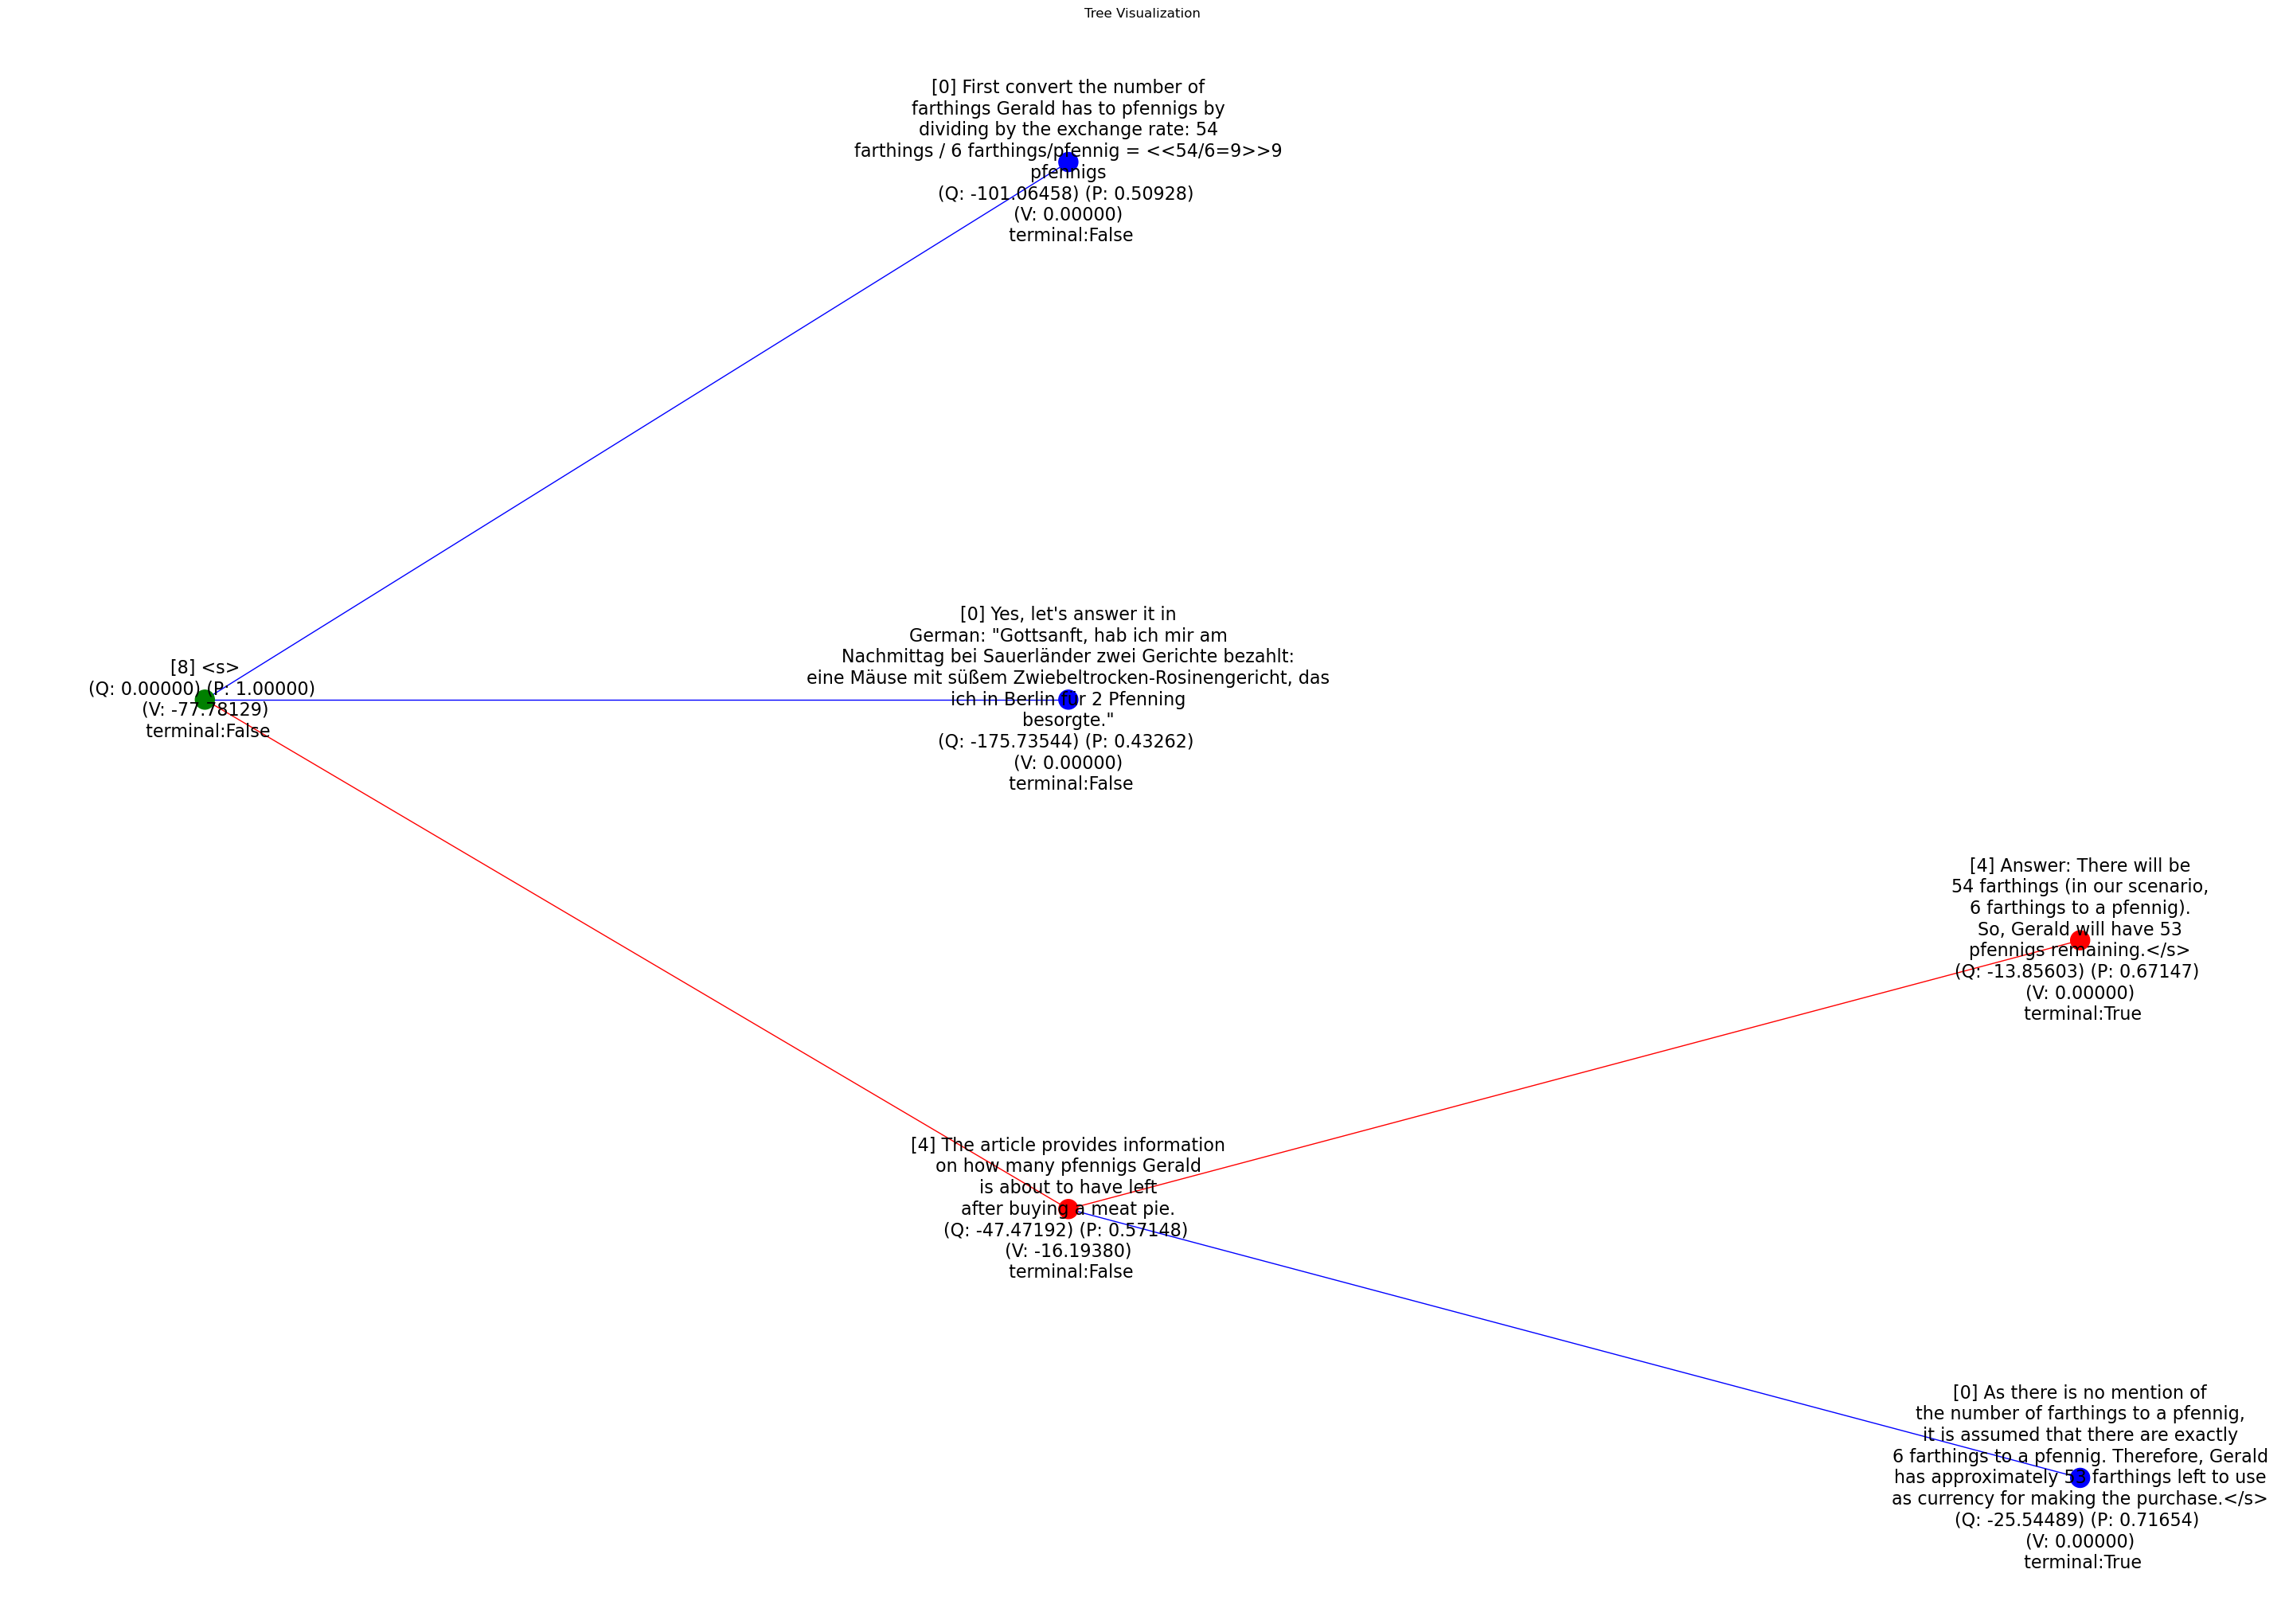

In [ ]:
iteration = 3
visualize_iteration_trees(output_dir, node_cnt, iteration)

## Predicted Path

/home/chalbeise/MCTS-DPO/MCTS-DPO/outputs/checkpoints/arithmetic/llama3-cdpo-2x2-gtsft/mcts_saved_trees_log_probs/epoch_0/batch_cnt_0/mcts_rst_predicted_path.pkl


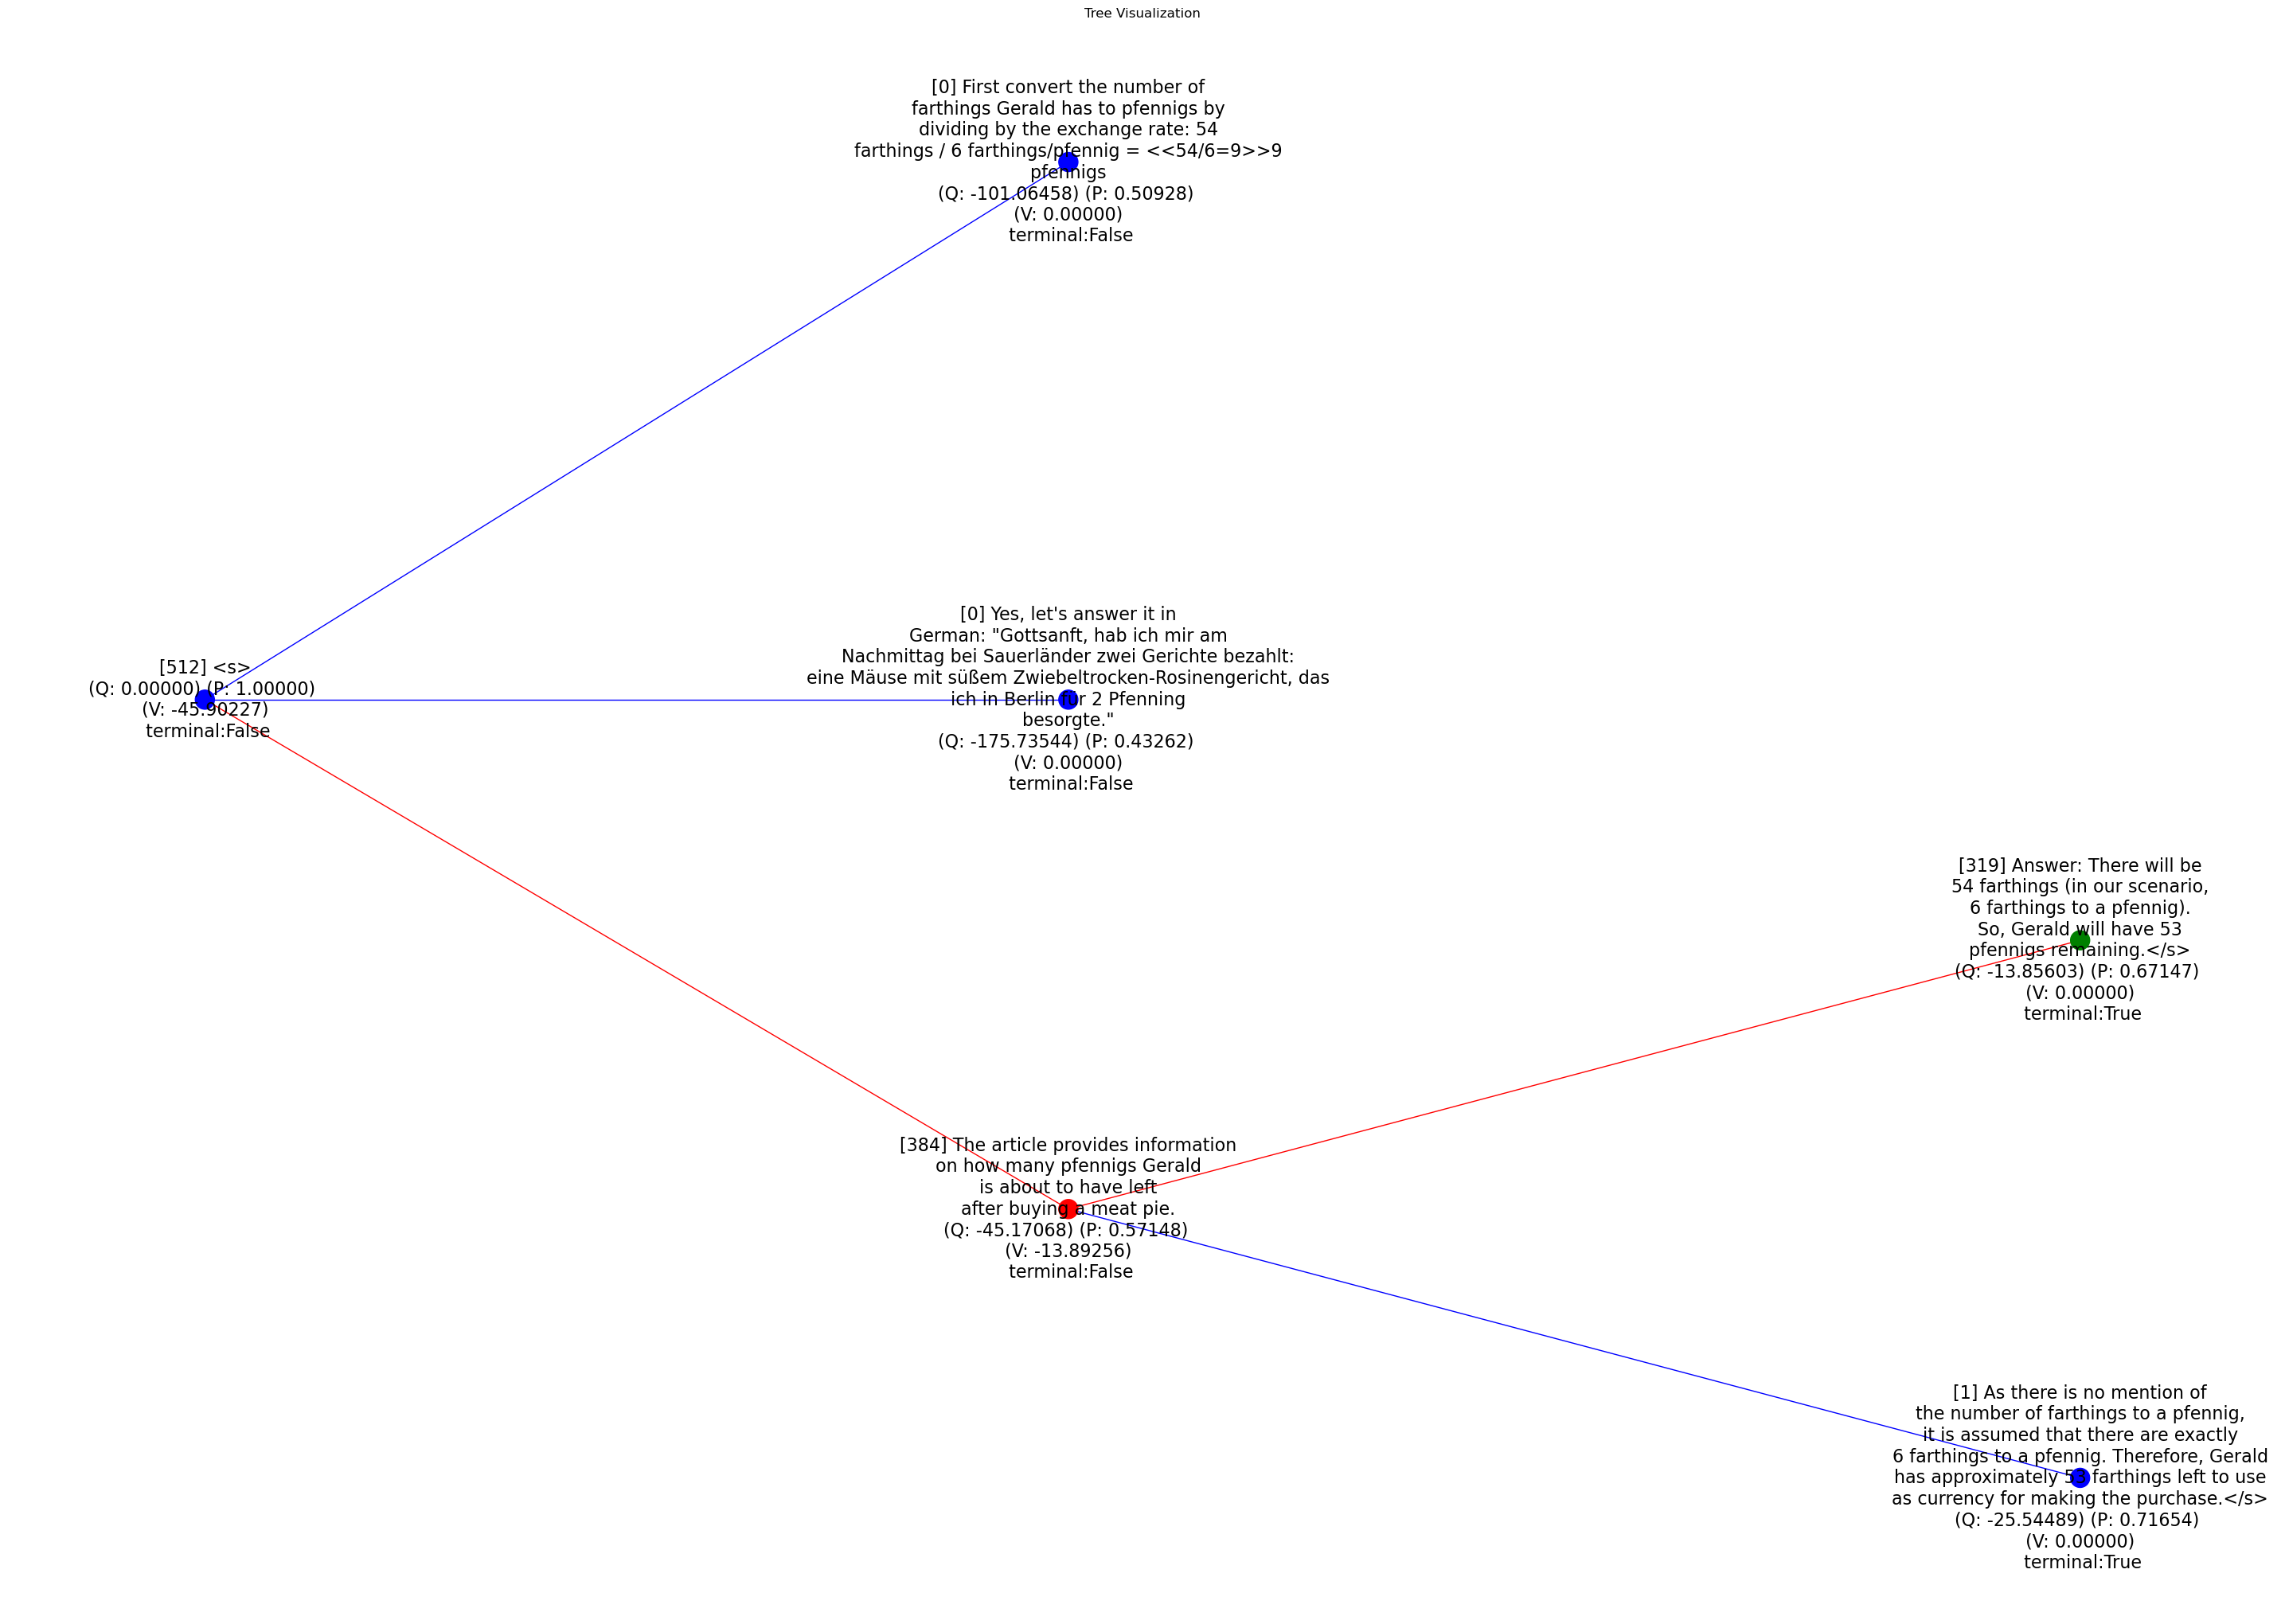

In [17]:
file = 'mcts_rst_predicted_path.pkl'
visualize_iteration_tree(f'{output_dir}', file)